# Artificial Neural Networks and Deep Learning

- Carlos Ruiz Aguirre
- Ariadna García Lorente
- Aman Saini 
- Marine Peuzet

### ⚠️ NOTEBOOK(1/2) ⚠️

## ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import cv2 as cv

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
import keras.layers as tfkl
import keras_cv.layers as tfklcv
from tensorflow.keras.applications import MobileNetV3Large


# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.0


## ⏳ Load the Data

In [8]:
data = np.load('training_set.npz')

images = data["images"]
labels = data["labels"]


print(f"Combined images shape: {images.shape}")
print(f"Combined labels shape: {labels.shape}")

Combined images shape: (13759, 96, 96, 3)
Combined labels shape: (13759, 1)


## 👁️ Show Rickroll and Shrek

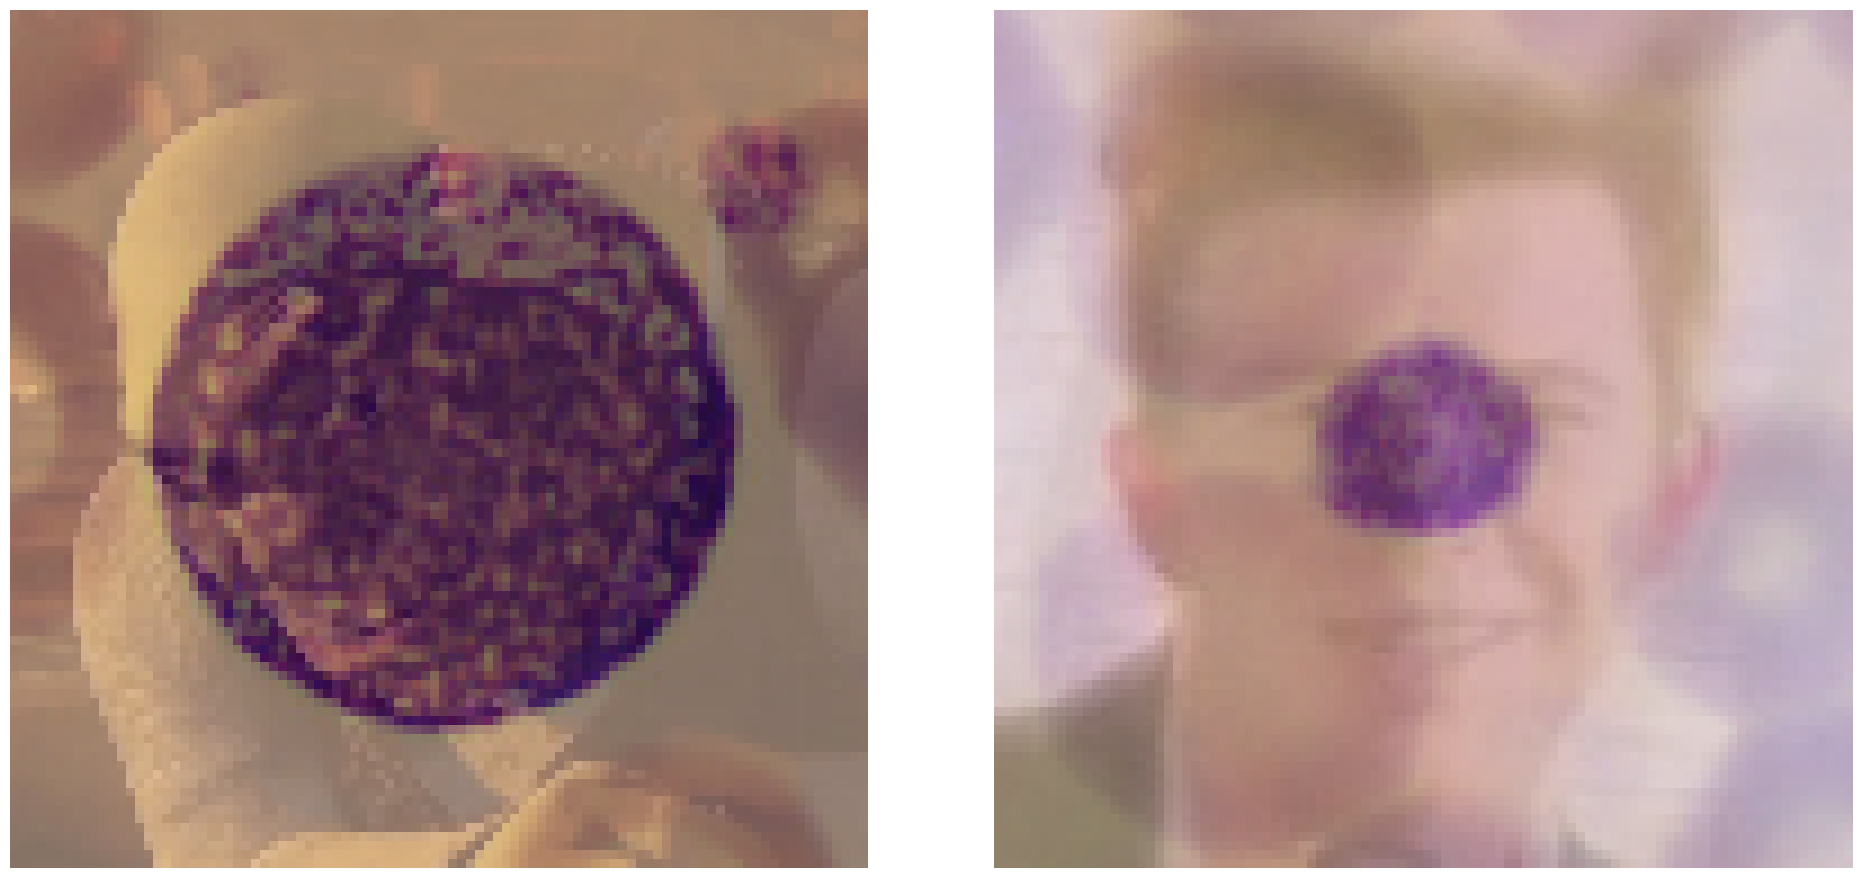

In [9]:
indexes = [12565, 13632]

# Create subplots
fig, axes = plt.subplots(len(indexes) // 2, 2, figsize=(20, 9))

for i, idx in enumerate(indexes):
    ax = axes[i]
    ax.imshow(np.clip(images[idx], 0, 255).astype(np.uint8))
    ax.set_xlabel(f"Label: {labels[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## ❌ Remove RickRolls

In [3]:
print(len(images))

# Reshape images if necessary
images_flattened = images.reshape(images.shape[0], -1)

# Convert to list format for DataFrame
df = pd.DataFrame({'images': list(images), 'labels': labels.flatten()})

# Function to compute perceptual hash for an image
def compute_phash(image_array):
    # Reshape image back to its original shape and convert to uint8 if needed
    image_reshaped = image_array.reshape(images.shape[1:]).astype(np.uint8)
    return cv.img_hash.pHash(image_reshaped).tobytes()  # Get a hash as bytes

# Calculate hashes for Shrek and Rickroll
shreck_hash = compute_phash(images[12565])
rickroll_hash = compute_phash(images[13632])

# Calculate the perceptual hash for each image and add it to a new column
df['image_hash'] = df['images'].apply(compute_phash)

# Filter out rows with hashes matching Shrek or Rickroll
df_cleaned = df[~df['image_hash'].isin([shreck_hash, rickroll_hash])].drop(columns=['image_hash']).reset_index(drop=True)

# Convert back to original format for kept data
images = np.array(df_cleaned['images'].tolist())
labels = df_cleaned['labels'].to_numpy()

# Output the number of removed rows for debugging
removed_rows = len(df) - len(df_cleaned)
print(f"Removed {removed_rows} images with Shrek or Rickroll hashes.")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, random_state=42)

# Normalize data to the range [0, 1]
X_train = (X_train / 255).astype('float32')
X_test = (X_test / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)



print(len(X_train) + len(X_test))

# Guarda las imágenes y etiquetas en un archivo .npz
output_file = "clean_dataset.npz"
np.savez(output_file, images=images, labels=labels)


13759
Removed 1800 images with Shrek or Rickroll hashes.
11959


## 🔍 Data Augmentation (Hard Augmentation)

I0000 00:00:1732484088.932093 1260937 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732484089.139847 1260937 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732484089.139887 1260937 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732484089.144654 1260937 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732484089.144706 1260937 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

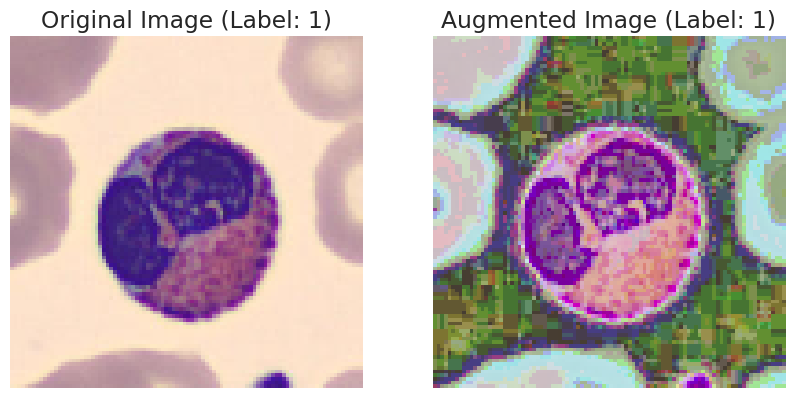

Augmented dataset saved as: augmented_dataset_hard.npz


In [ ]:
# Load the cleaned dataset containing images and labels
clean_data = np.load('clean_dataset.npz')
images = clean_data["images"]
labels = clean_data["labels"]

# Define a sequential data augmentation pipeline using AugMix and RandAugment
cv_augmentation = tf.keras.Sequential([
    tfklcv.AugMix(  # AugMix adds severe yet controlled augmentations
        value_range=(0, 255),  # Range of pixel values for normalization
        severity=0.9,  # Level of augmentation severity
        num_chains=1,  # Number of augmentation chains applied
        chain_depth=[1, 3],  # Depth of augmentation chains (min and max)
    ),
    tfklcv.RandAugment(  # RandAugment applies random augmentations
        value_range=(0, 255),  # Range of pixel values for normalization
        augmentations_per_image=1,  # Number of augmentations per image
        magnitude=0.9,  # Magnitude of the augmentations
    ),
])

# Prepare arrays to store augmented images and labels
augmented_images = []
augmented_labels = []

# Loop through each image and its label to apply augmentations
for i in range(len(images)):
    image = images[i]
    label = labels[i]

    # Apply the augmentation pipeline to the image
    augmented_image = cv_augmentation(tf.expand_dims(image, axis=0))[0]
    
    # Append the augmented image and the corresponding label to their respective lists
    augmented_images.append(augmented_image.numpy())
    augmented_labels.append(label)

# Convert the augmented data into NumPy arrays for saving
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Save the augmented dataset to a compressed NPZ file
output_file = "augmented_dataset_hard.npz"
np.savez(output_file, images=augmented_images, labels=augmented_labels)

# Randomly select an index to visualize an example of original and augmented images
random_index = np.random.randint(len(augmented_images))
original_image = images[random_index]
augmented_image = augmented_images[random_index]
label = augmented_labels[random_index]

# Plot the original and augmented images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
axes[0].imshow(np.clip(original_image, 0, 255).astype(np.uint8))
axes[0].set_title(f"Original Image (Label: {labels[random_index]})")
axes[0].axis('off')  # Hide axes for better visualization

# Display the augmented image
axes[1].imshow(np.clip(augmented_image, 0, 255).astype(np.uint8))
axes[1].set_title(f"Augmented Image (Label: {label})")
axes[1].axis('off')  # Hide axes for better visualization

# Show the side-by-side comparison
plt.show()

# Confirm that the augmented dataset has been successfully saved
print(f"Augmented dataset saved as: {output_file}")

## 🔍 Data Augmentation (Medium Augmentation)

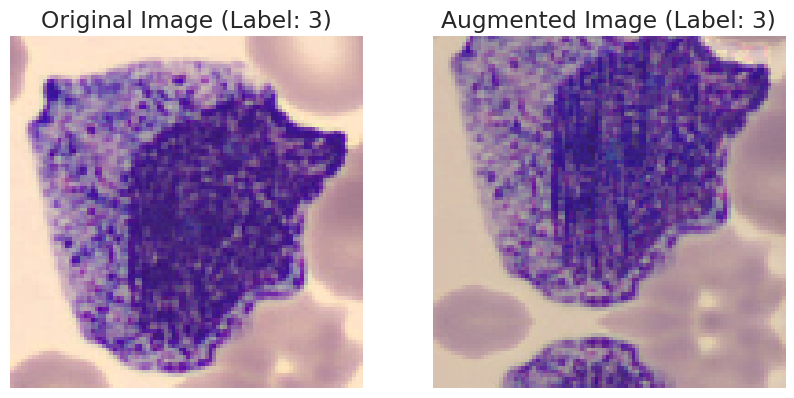

Augmented dataset saved as: augmented_dataset_medium.npz


In [ ]:
# Define a sequential data augmentation pipeline using AugMix and RandAugment
cv_augmentation = tf.keras.Sequential([
    tfklcv.AugMix(  # AugMix applies moderate augmentations to the images
        value_range=(0, 255),  # Normalize pixel values within this range
        severity=0.5,  # Moderate augmentation severity level
        num_chains=1,  # Single chain of augmentations
        chain_depth=[1, 3],  # Random depth for augmentation chain (between 1 and 3)
    ),
    tfklcv.RandAugment(  # RandAugment applies random augmentations
        value_range=(0, 255),  # Normalize pixel values within this range
        augmentations_per_image=1,  # One augmentation applied per image
        magnitude=0.5,  # Moderate augmentation intensity
    ),
])

# Initialize lists to store augmented images and corresponding labels
augmented_images = []
augmented_labels = []

# Apply augmentations to each image in the dataset
for i in range(len(images)):
    image = images[i]  # Get the original image
    label = labels[i]  # Get the corresponding label
    
    # Apply the augmentation pipeline
    augmented_image = cv_augmentation(tf.expand_dims(image, axis=0))[0]
    
    # Add the augmented image and label to their respective lists
    augmented_images.append(augmented_image.numpy())
    augmented_labels.append(label)

# Convert the augmented images and labels into NumPy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Save the augmented dataset into a compressed NPZ file
output_file = "augmented_dataset_medium.npz"
np.savez(output_file, images=augmented_images, labels=augmented_labels)

# Randomly select an image to visualize its original and augmented versions
random_index = np.random.randint(len(augmented_images))
original_image = images[random_index]
augmented_image = augmented_images[random_index]
label = augmented_labels[random_index]

# Plot the original and augmented images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
axes[0].imshow(np.clip(original_image, 0, 255).astype(np.uint8))
axes[0].set_title(f"Original Image (Label: {labels[random_index]})")
axes[0].axis('off')  # Hide axes for better visualization

# Display the augmented image
axes[1].imshow(np.clip(augmented_image, 0, 255).astype(np.uint8))
axes[1].set_title(f"Augmented Image (Label: {label})")
axes[1].axis('off')  # Hide axes for better visualization

# Show the side-by-side comparison of original and augmented images
plt.show()

# Print confirmation that the augmented dataset has been saved
print(f"Augmented dataset saved as: {output_file}")


## 🔍 Data Augmentation (Light Augmentation)

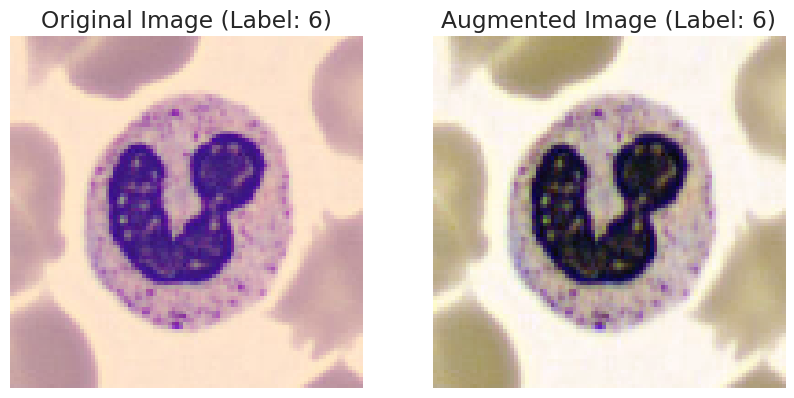

Augmented dataset saved as: augmented_dataset.npz


In [ ]:
# Define a sequential data augmentation pipeline using AugMix and RandAugment
cv_augmentation = tf.keras.Sequential([
    tfklcv.AugMix(  # AugMix applies light augmentations to the images
        value_range=(0, 255),  # Normalize pixel values within this range
        severity=0.1,  # Low severity level for augmentations
        num_chains=1,  # Single chain of augmentations
        chain_depth=[1, 3],  # Random depth for the augmentation chain (between 1 and 3)
    ),
    tfklcv.RandAugment(  # RandAugment applies random light augmentations
        value_range=(0, 255),  # Normalize pixel values within this range
        augmentations_per_image=1,  # One augmentation applied per image
        magnitude=0.1,  # Low intensity for augmentations
    ),
])

# Initialize lists to store augmented images and their corresponding labels
augmented_images = []
augmented_labels = []

# Loop through each image and apply augmentations
for i in range(len(images)):
    image = images[i]  # Retrieve the original image
    label = labels[i]  # Retrieve the corresponding label
    
    # Apply the augmentation pipeline to the image
    augmented_image = cv_augmentation(tf.expand_dims(image, axis=0))[0]
    
    # Append the augmented image and its label to the respective lists
    augmented_images.append(augmented_image.numpy())
    augmented_labels.append(label)

# Convert the augmented images and labels to NumPy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Save the augmented dataset to a compressed NPZ file
output_file = "augmented_dataset.npz"
np.savez(output_file, images=augmented_images, labels=augmented_labels)

# Randomly select an image for visualization
random_index = np.random.randint(len(augmented_images))
original_image = images[random_index]
augmented_image = augmented_images[random_index]
label = augmented_labels[random_index]

# Create a side-by-side comparison of the original and augmented images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
axes[0].imshow(np.clip(original_image, 0, 255).astype(np.uint8))
axes[0].set_title(f"Original Image (Label: {labels[random_index]})")
axes[0].axis('off')  # Hide axes for better visualization

# Display the augmented image
axes[1].imshow(np.clip(augmented_image, 0, 255).astype(np.uint8))
axes[1].set_title(f"Augmented Image (Label: {label})")
axes[1].axis('off')  # Hide axes for better visualization

# Show the comparison plot
plt.show()

# Print confirmation that the augmented dataset has been saved
print(f"Augmented dataset saved as: {output_file}")
